### Seqlet Calling and Downstream Analyses

A key set of functionality implemented in tangermeme relates to the identification and usage of <i>seqlets</i>. Seqlets are short contiguous regions of the genome that have been identified as driving model predictions, usually through the use of an attribution method (e.g., DeepLIFT/SHAP). They also usually correspond biologically to a transcription factor (TF) binding site or some other important <i>cis-</i>regulatory element. The term "seqlet" was introduced in as the first step in the TF-MoDISco algorithm, with the subsequent steps involving processing and clustering these seqlets to find repeated patterns.

In the pipeline of automatically extracting insights from sequence-based machine learning methods, seqlet calling comes directly after attributions and is, in many cases, the step where we transition from contiguous-based analyses to discrete logic-based ones. For instance, having an attribution track is nice as a visual and may help explain what is happening at an individual locus, but requires annotation, "there is an AP-1 binding site here". This annotation is done through seqlet calling on the attributions, followed by seqlet annotation using a motif database.

Here, we will show how seqlets can be helpful when making concrete statements about what a model is focusing on at individual regions, and then use them to more globally characterize the logic that has been learned by a model.

### Loading Models

First, we will load five models that make predictions for overlapping forms of biochemical activity. Specifically, we will load 

1. a BPNet model that predicts E2F3 binding
2. a BPNet model that predicts MYC binding
3. Beluga using its MYC binding predictions
4. a ChromBPNet model that predicts accessibility
5. a ProCapNet model that predicts transcription initiation

All models are making predictions in the K562 cell line.

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')

import sys
import torch

from bpnetlite import BPNet
from bpnetlite.bpnet import ControlWrapper
from bpnetlite.bpnet import CountWrapper


e2f3_bpnet = torch.load("../../../../models/bpnet/E2F3.torch", weights_only=False)
e2f3_bpnet = CountWrapper(ControlWrapper(e2f3_bpnet))

myc_bpnet = torch.load("../../../../models/bpnet/MYC.torch", weights_only=False)
myc_bpnet = CountWrapper(ControlWrapper(myc_bpnet))

sys.path.append("/users/jacob.schreiber/models/deepsea")
from beluga import Beluga

class BelugaWrapper(torch.nn.Module):
    def __init__(self, model, target):
        super().__init__()
        self.model = model
        self.target = target
    
    def forward(self, X):
        return self.model(X[:, :, 57:-57])[:, self.target:self.target+1]

beluga = Beluga()
beluga.load_state_dict(torch.load("../../../../models/deepsea/deepsea.beluga.pth", weights_only=False))
beluga = BelugaWrapper(beluga, 614)

chrombpnet = BPNet.from_chrombpnet("../../../../models/chrombpnet/fold_0/model.chrombpnet_nobias.fold_0.ENCSR868FGK.h5")
chrombpnet = CountWrapper(chrombpnet)

procapnet = BPNet(512, n_outputs=2, n_control_tracks=0)
procapnet.load_state_dict(torch.load("../../../../models/procapnet/procapnet_model.fold0.torch", weights_only=False))
procapnet = CountWrapper(procapnet)

models = e2f3_bpnet, myc_bpnet, beluga, chrombpnet, procapnet

### Calling seqlets at a single locus

Now, we will load up the promoter of PLD6 as well as a variety of other MYC binding peaks across the genome to use as a background distribution for our seqlet calling.

In [2]:
import pandas

from tangermeme.io import extract_loci

# PLD6
df = pandas.DataFrame({
    'chrom': ['chr1'],
    'start': [11_060_020 - 2114 // 2],
    'end': [11_060_020 + 2114 // 2]
})

X = extract_loci([df, "ENCFF114VAI.bed.gz"], "/users/jacob.schreiber/common/hg38.fa", n_loci=100).float()
X.shape

torch.Size([100, 4, 2114])

Then, we can calculate attributions for each model.

In [3]:
from tangermeme.deep_lift_shap import deep_lift_shap

X_attr = torch.stack([
    deep_lift_shap(model, X, batch_size=4, verbose=True, warning_threshold=0.01, random_state=0)[0] for model in models
])

X_attr.shape

100%|██████████| 2000/2000 [00:57<00:00, 34.89it/s]


torch.Size([5, 4, 2114])

With these attributions, we can now call seqlets using the built-in `recursive_seqlets` function. For more details on how that algorithm works, see the seqlet calling tutorial. As a brief description, we are empirically finding spans of characters whose attribution is above what one would expect by chance, and we are then post-processing these spans to additionally have 2bp on either side because the seqlets are usually a bit conservative in their width. The "core" part of these seqlets cannot overlap, but the additional flanking bp are allowed to overlap each other and also overlap the "core" part of another seqlet.

In [4]:
from tangermeme.seqlet import recursive_seqlets

X_seqlet = [
    recursive_seqlets(X_attr[i:i+1].sum(dim=1), additional_flanks=2) for i in range(len(models))
]

X_seqlet[1]

,example_idx,start,end,attribution,p-value
0,0,1243,1259,0.388328,0.000046
1,0,595,608,0.135827,0.003955
2,0,1025,1033,0.091028,0.008905


Finally, we can visualize the results. We will be showing the attributions from each of the models at the TSS of PLD6 as well as bars under the attributions indicating where the called seqlets are.

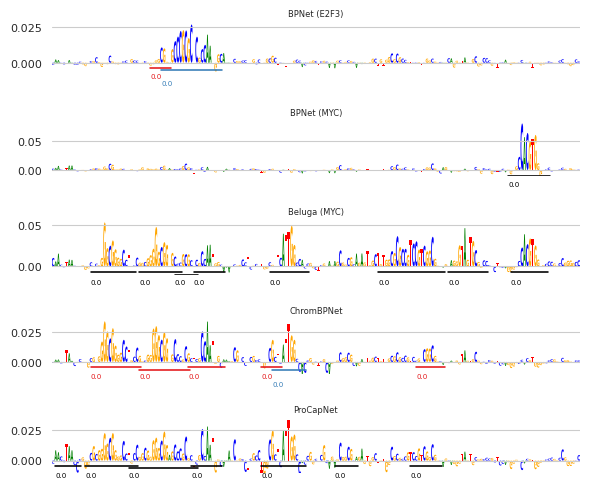

In [5]:
from tangermeme.plot import plot_logo

s, e = 1075, 1270

names = "BPNet (E2F3)", "BPNet (MYC)", "Beluga (MYC)", "ChromBPNet", "ProCapNet"

plt.figure(figsize=(6, 5))

for i in range(len(models)):
    plt.subplot(len(models), 1, i+1)
    plt.title(names[i], fontsize=6)
    plot_logo(X_attr[i], annotations=X_seqlet[i], start=s, end=e, show_score=False, score_key='attribution')
    plt.yticks(fontsize=8)
    plt.ylim(-0.01, plt.gca().get_ylim()[1])
    plt.xticks([], [])

plt.tight_layout()
plt.show()

It looks like the algorithm is calling seqlets on many of the contiguous spans that one might do by eye. Unfortunately, seqlet calling is a somewhat subjective task with no clear definitions as to when something definitely is or is not a seqlet. Based on my prior experience, this is a fairly clean segmentation of the attribution scores into seqlets, particularly when considering some of the more complex and close-together sequence features.

Remember, the attribution calculations and seqlet calling are being done independently on each of the models. It is somewhat remarkable to see how different models -- trained to predict different readouts -- can have such similar attributions. One could view this stability as a sign of the robustness of such an interpretation approach.

An interesting result here is that the Beluga (MYC) model appears to highlight almost a union of all the motifs found by the models. Basically, it seems to identify that the MYC motif is driving MYC binding, but it is also picking up that all of the motifs associated with chromatin accessibility are also associated with MYC binding. This is not necessarily incorrect, in the sense that an accessible region may have stronger binding of non-pioneer factors than an inaccessible region, but it does mean that the model is less specific to the sequence factors driving MYC binding.

### Annotating seqlets at a single locus

Now that we have our seqlets, we can map the discrete sequence within them to a motif database using Tomtom to automatically determine what motifs are being picked up by our models. Note that the choice of motif database is VERY important in this step. If you use one with ambiguous names or full of redundancy you may end up with fuzzier mappings than if you use one that is less redundant and with cleaner names. Here, we will use all motifs from JASPAR2024 that are derived from human ChIP-seq experiments.

In [6]:
import numpy
from tangermeme.io import read_meme
from tangermeme.annotate import annotate_seqlets

motifs = read_meme("JASPAR2024_homo_sapiens_chipseq.meme")
motif_names = numpy.array([name.split('.')[-1] for name in motifs.keys()]) # Remove the MA... from the name

for i in range(5):
    idxs, pvals = annotate_seqlets(X, X_seqlet[i], motifs)
    X_seqlet[i]['example_idx'] = motif_names[idxs[:, 0].numpy()]
    
X_seqlet[1]

,example_idx,start,end,attribution,p-value
0,MYCN,1243,1259,0.388328,0.000046
1,MYC,595,608,0.135827,0.003955
2,ZNF610,1025,1033,0.091028,0.008905


Looks like our MYC BPNet model is picking up two MYC motifs and a zinc-finger motif in this region.

Now we can plot the attributions and seqlet calls again but, instead of having an uninformative "0" under each seqlet, we can have the name of the motif that maps there.

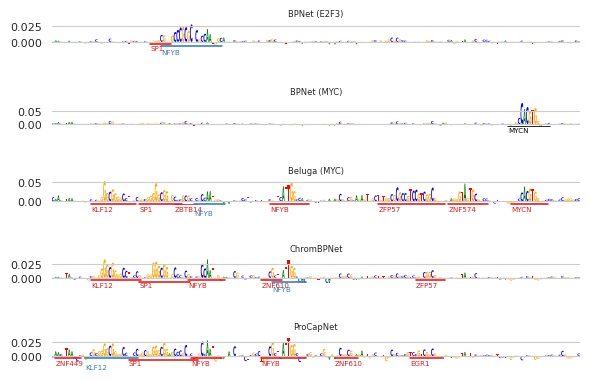

In [7]:
s, e = 1075, 1270

names = "BPNet (E2F3)", "BPNet (MYC)", "Beluga (MYC)", "ChromBPNet", "ProCapNet"

plt.figure(figsize=(6, 4))

for i in range(len(models)):
    plt.subplot(len(models), 1, i+1)
    plt.title(names[i], fontsize=6)
    plot_logo(X_attr[i], annotations=X_seqlet[i], start=s, end=e, show_score=False, score_key='attribution')
    plt.yticks(fontsize=8)
    plt.ylim(-0.01, plt.gca().get_ylim()[1])
    plt.xticks([], [])

plt.tight_layout()
#plt.savefig("tangermeme-fig2-attr.pdf")
plt.show()

Looking here, we can see that the story is cleaner to explain in words when using the annotated seqlets than when using only the attributions: the BPNet model predicting MYC picks up on the MYC model, the ChromBPNet model picks up on several motifs including SP-1 and NFYB, which are known to be active in K562, and the ProCapNet model picks up on the same motifs as the ChromBPNet model. The E2F3 model is picking up on an extended form of the motif that seems to be overlapping with the NFYB site here.

A key point to take away from this procedure is that, although it is automatic (perhaps <i>because</i> it is automatic), user verification may be necessary, particularly in some of the more complicated cases.

### Large-scale analysis using seqlets

Being able to describe what is happening at an individual locus through the lens of annotated seqlets can be invaluable, but this can be scaled up to describe the global patterns of what is driving model predictions across the entire genome. Here, we will essentially repeat the same process that we employed for the individual locus, except do so across a large number of MYC binding sites across the genome. We will focus on comparing the MYC BPNet model and the MYC beluga model because they seemed to learn such different forms of activity.

In [8]:
X = extract_loci("ENCFF114VAI.bed.gz", "/users/jacob.schreiber/common/hg38.fa").float()
X = X[X.sum(dim=(-1, -2)) == X.shape[-1]]

X_attr = torch.stack([
    deep_lift_shap(model, X, verbose=True, warning_threshold=0.01, random_state=0) for model in models[1:3]
])

X_attr.shape

 57%|█████▋    | 113088/199160 [10:20<07:50, 182.83it/s]/users/jacob.schreiber/github/tangermeme/tangermeme/deep_lift_shap.py:460: RuntimeWarning: Convergence deltas too high: tensor([9.5367e-07, 9.5367e-07, 9.5367e-07, 7.1526e-07, 1.1921e-07, 3.5763e-06,
        9.5367e-07, 5.9605e-07, 1.4305e-06, 4.7684e-07, 2.9206e-06, 7.1526e-07,
        2.8610e-06, 4.7684e-07, 3.3379e-06, 4.7684e-07, 3.3379e-06, 4.7684e-07,
        1.4305e-06, 1.1921e-06, 0.0000e+00, 4.2915e-06, 9.5367e-07, 9.5367e-07,
        4.7684e-07, 1.2118e-02, 1.9073e-06, 9.5367e-07, 1.6689e-06, 1.9073e-06,
        1.1921e-06, 2.3842e-06], device='cuda:0', grad_fn=<AbsBackward0>)
  warnings.warn("Convergence deltas too high: " +
100%|██████████| 199160/199160 [18:15<00:00, 181.72it/s]


torch.Size([2, 9958, 4, 2114])

Then, we will call seqlets again for each of them. Using the additional flanking positions here can be especially helpful because sometimes an overly conservative seqlet call can exclude flanking nucleotides that are useful for distinguishing between several similar motifs in a redundant datbase.

In [9]:
X_seqlet = [
    recursive_seqlets(X_attr[i].sum(dim=1), threshold=0.001, additional_flanks=2) for i in range(X_attr.shape[0])
]

X_seqlet[0].head()

,example_idx,start,end,attribution,p-value
0,3520,1047,1066,0.838357,4.305052e-08
1,3229,1009,1025,0.613310,7.472241e-08
2,1766,1004,1022,0.713385,7.688517e-08
3,2650,1088,1106,0.727878,8.623045e-08
4,456,1013,1032,0.717326,2.219866e-07


To get a more objective view of how well this seqlet calling algorithm works, let's just scan through 20 regions and see what the attributions and the seqlet calls look like.

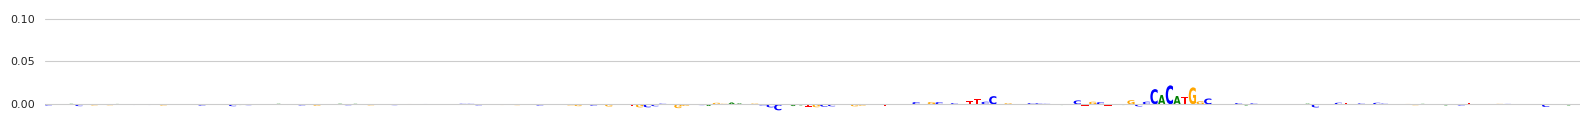

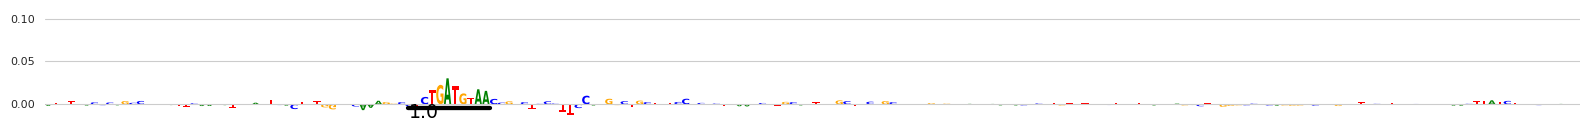

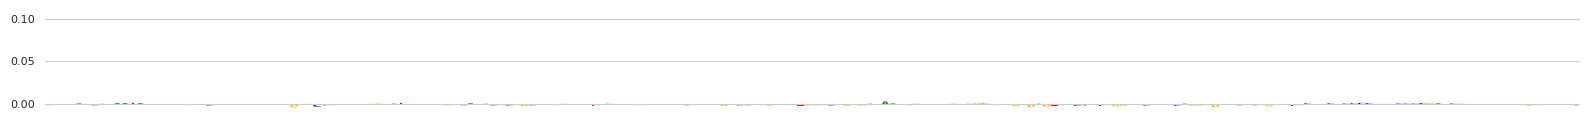

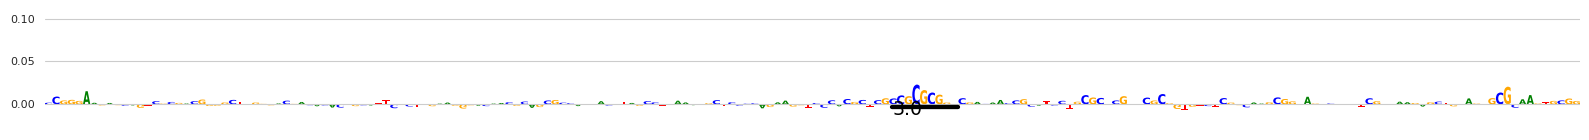

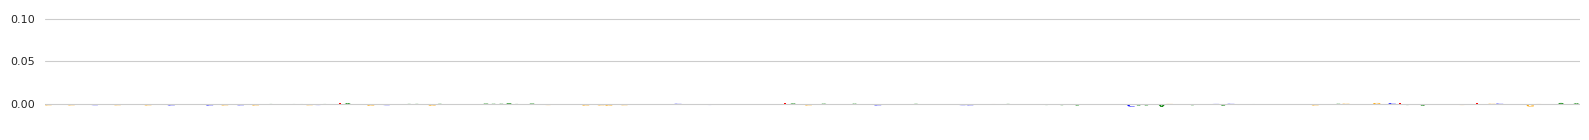

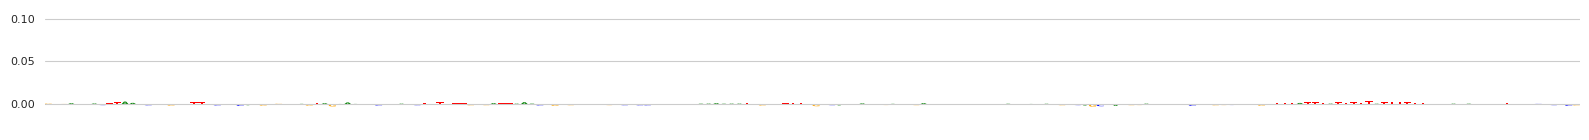

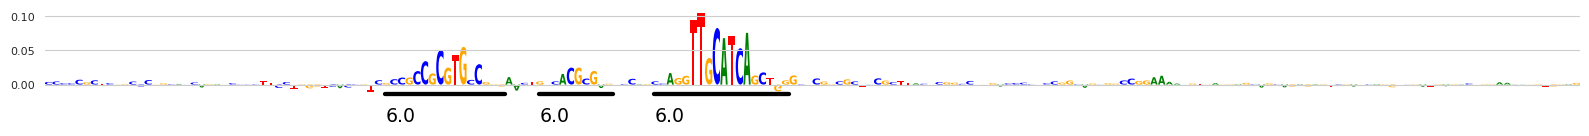

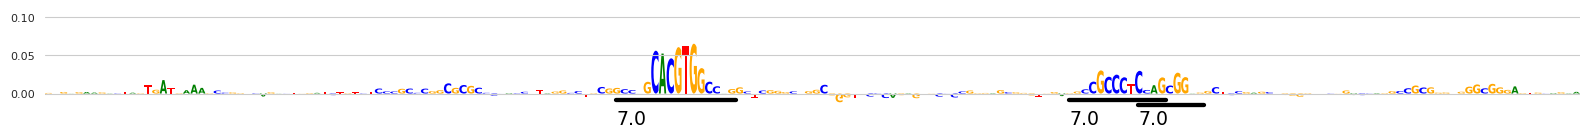

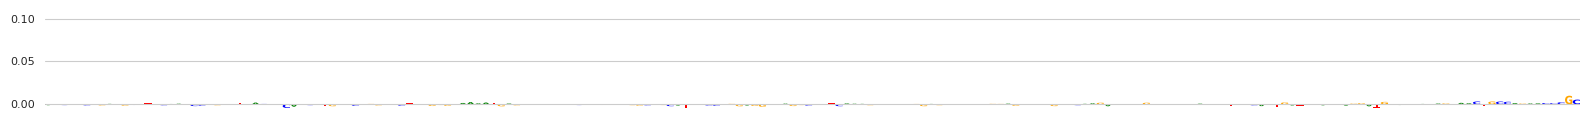

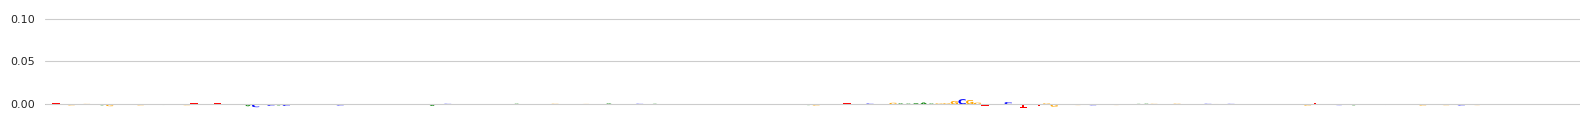

In [10]:
s, e = 1050, 1250

for eidx in range(10):
    plt.figure(figsize=(16, 1.5))

    ann_ = X_seqlet[0]
    ann_ = ann_[ann_['example_idx'] == eidx]

    plot_logo(X_attr[0][eidx], start=s, end=e, annotations=ann_, show_score=False, score_key='attribution')

    plt.yticks(fontsize=8)
    plt.ylim(-0.03, 0.11)
    plt.xticks([], [])
    plt.tight_layout()
    plt.show()

We can now go through and annotate each of these seqlet calls and then count the number of annotations in each example using the `count_annotations` function.

In [11]:
from tangermeme.annotate import count_annotations

counts = []

for i in range(2):
    idxs, pvals = annotate_seqlets(X, X_seqlet[i], motifs)
    seqlets = (X_seqlet[i]['example_idx'], idxs[:, 0])
    
    counts_ = count_annotations(seqlets, shape=(len(X), len(motif_names))).float()
    counts.append(counts_)
    
counts = torch.stack(counts)
counts.shape

torch.Size([2, 9958, 251])

We can see how many seqlets are being called per instance with the two models on average.

In [12]:
counts[0].sum(dim=-1).mean().item(), counts[1].sum(dim=-1).mean().item()

(1.4251857995986938, 1.6104639768600464)

Looks like the Beluga model is calling slightly more seqlets on average than the BPNet model is.

We can then look at what motifs are being used to annotate seqlets for each of the two models to see whether there seem to be broad differences in the sorts of motifs that are being picked up on.

In [13]:
motif_counts = counts.sum(dim=1).numpy()
motif_idxs = motif_counts.sum(axis=0).argsort()[::-1]


for idx in motif_idxs[:15]:
    print("{:15}\t{:5.5}\t{:5.5}".format(motif_names[idx], motif_counts[0][idx], motif_counts[1][idx]))

MYC            	2436.0	976.0
MYCN           	1622.0	405.0
MXI1           	1619.0	383.0
ZBTB11         	653.0	827.0
HIF1A          	913.0	443.0
GATA3          	160.0	678.0
NRF1           	276.0	537.0
GATA2          	199.0	537.0
YY2            	280.0	399.0
YY1            	 43.0	630.0
IKZF2          	142.0	508.0
GATA4          	162.0	469.0
ATF4           	427.0	202.0
KLF15          	143.0	458.0
CTCFL          	308.0	281.0


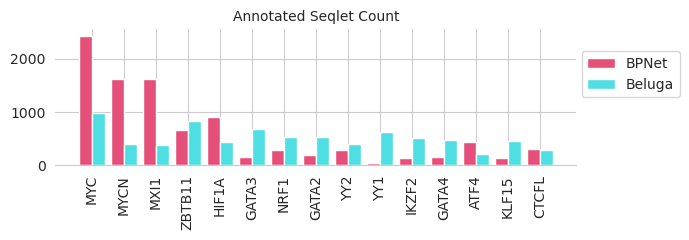

In [14]:
plt.figure(figsize=(7, 2.5))
plt.title("Annotated Seqlet Count", fontsize=10)
plt.bar(numpy.arange(15)-0.2, motif_counts[0][motif_idxs[:15]], width=0.4, facecolor="#e5507a", label="BPNet")
plt.bar(numpy.arange(15)+0.2, motif_counts[1][motif_idxs[:15]], width=0.4, facecolor="#50dee5", label="Beluga")
plt.xticks(range(15), motif_names[motif_idxs[:15]], rotation=90)

plt.legend(loc=(1.01, 0.5))
seaborn.despine(left=True)
plt.tight_layout()
#plt.savefig("tangermeme-fig2-seqlet-count.pdf")
plt.show()

Looks like there are clear differences between the two. The MYC BPNet model mostly yields seqlets that are annotated with MYC-related motifs, whereas the Beluga model seems to focus on YY1 ones and actually seems underrepresented for the MYC ones!

Next, we can consider more sophisticated aspects of the logic in the genome. First, we can consider what sorts of pairs of seqlets appear together in the same examples.

In [15]:
from tangermeme.annotate import pairwise_annotations

pairwise_counts = []

for i in range(2):
    idxs, pvals = annotate_seqlets(X, X_seqlet[i], motifs)
    seqlets = (X_seqlet[i]['example_idx'], idxs[:, 0])
    
    counts_ = pairwise_annotations(seqlets, shape=len(motif_names)).float()
    pairwise_counts.append(counts_)
    
pairwise_counts = torch.stack(pairwise_counts)
pairwise_counts.shape

torch.Size([2, 251, 251])

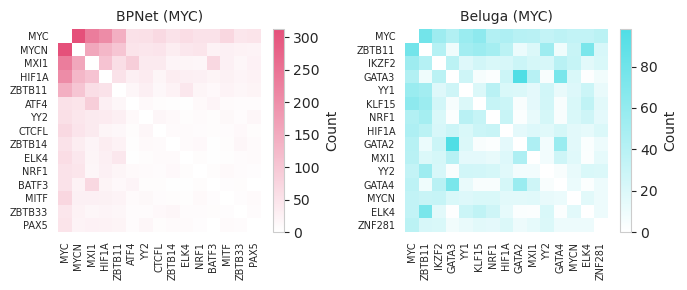

In [16]:
import matplotlib

cmap0 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", "#e5507a"])
cmap1 = matplotlib.colors.LinearSegmentedColormap.from_list("", ["white", "#50dee5"])

idx0 = pairwise_counts[0].sum(dim=0).argsort().numpy()[::-1].copy()[:15]
idx1 = pairwise_counts[1].sum(dim=0).argsort().numpy()[::-1].copy()[:15]

plt.figure(figsize=(7, 3))
plt.subplot(121)
plt.title("BPNet (MYC)", fontsize=10)
plt.imshow(pairwise_counts[0][idx0][:, idx0], cmap=cmap0, aspect='auto')
plt.yticks(range(len(idx0)), motif_names[idx0], fontsize=7)
plt.xticks(range(len(idx0)), motif_names[idx0], rotation=90, fontsize=7)
plt.colorbar(label="Count")
plt.grid(False)
seaborn.despine(bottom=True, left=True)

plt.subplot(122)
plt.title("Beluga (MYC)", fontsize=10)
plt.imshow(pairwise_counts[1][idx1][:, idx1], cmap=cmap1, aspect='auto')
plt.yticks(range(len(idx0)), motif_names[idx1], fontsize=7)
plt.xticks(range(len(idx0)), motif_names[idx1], rotation=90, fontsize=7)
plt.grid(False)
seaborn.despine(bottom=True, left=True)

plt.colorbar(label="Count")
plt.tight_layout()
#plt.savefig("tangermeme-fig2-pairwise.pdf")
plt.show()